# Image captioning

### Introduction
                Humans are creative creatures, we can easily look at an image and can describe that image. What about a computer ?. Advent of deep learning made this very simple. Here we see, how can a computer describe the image .

## Importing necessary packages

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


### Summary
            Importing all the necessary packages.

### Loading text document

In [2]:
def load_document(filename):
    file = open(filename, 'r') #opening the file
    text = file.read() # reading the all text in the file
    file.close() #closing the file
    return text # textr is returned here

filename = "text_data/Flickr8k.token.txt" # Giving the filepath
document = load_document(filename) # Document is loaded here
print(document[865:1389]) # displaying the document


1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8.jpg#1	A little girl is sitting in front of a large painted rainbow .
1002674143_1b742ab4b8.jpg#2	A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
1002674143_1b742ab4b8.jpg#3	There is a girl with pigtails sitting in front of a rainbow painting .
1002674143_1b742ab4b8.jpg#4	Young girl with pigtails painting outside in the grass .


### Summary
            loading the document, and displayng the  document.

### Visualizing the image for above text

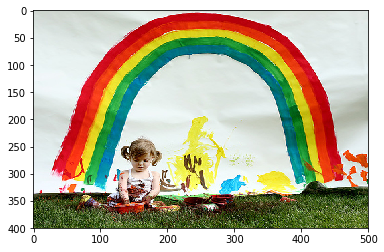

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

img = mpimg.imread('image_data/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg')
plt.imshow(img, aspect='auto')
plt.show()

### Summary
                Displaying the image, from the loaded document.

### Processing the text documents

In [4]:
def create_dict(document): # idea here is to make image_id as the key and description of image as value to dictionary
    dictionary=dict() # creating empty dictionary
    for line in document.split('\n'): # Splitting the document for every new line
        token=line.split() # Splitting the line for every white space
        if len(line) < 2: # if the line length is less than 2, we are ingoring the line
            continue
        img_id,img_desc=token[0],token[1:] # 1st split part of line is taken as img_id, remaining part is taken as image description
        img_id=img_id.split('.')[0] #Splitting the line and taking only img_id number, neglecting the format
        img_desc=' '.join(img_desc) # Joining all the descriptions with white space
        if img_id not in dictionary: # if img_id is not in the dictionary, we are creating a empty list and assigning it to the key
            dictionary[img_id]=list()
        dictionary[img_id].append(img_desc) # for every img_id as key, we are giving description as value
    return dictionary
descriptions=create_dict(document)
print('Loaded: ',len(descriptions))

Loaded:  8092


### Summary
            Here we are creating a dictionary,i.e., image id's as keys and descriptions as values to the keys.

In [5]:
list(descriptions.keys())[:10]

['3437034427_6df5e9fbf9',
 '3564312955_716e86c48b',
 '3507670136_2e5f94accf',
 '3481884992_45770ec698',
 '373219198_149af371d9',
 '3042483842_beb23828b9',
 '262570082_6364f58f33',
 '2866696346_4dcccbd3a5',
 '3598447435_f66cd10bd6',
 '3103264875_2a8d534abc']

### Checking whether all the descriptions are correctly matched to image_id's.

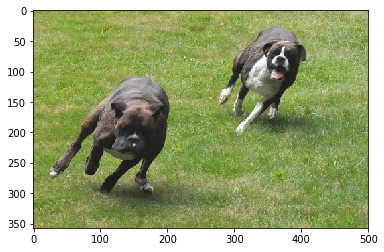

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

img = mpimg.imread('image_data/Flicker8k_Dataset/3583065748_7d149a865c.jpg')
plt.imshow(img, aspect='auto')
plt.show()

In [7]:
descriptions['3583065748_7d149a865c']

['A black and a black dog are running .',
 'A black and white dog chases a bigger dog across the grass .',
 'One dog chases another in the grass .',
 'Two brindle dogs running in the grass .',
 'Two dogs run through the grass .']

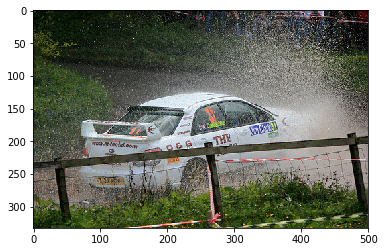

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

img = mpimg.imread('image_data/Flicker8k_Dataset/2528521798_fb689eba8d.jpg')
plt.imshow(img, aspect='auto')
plt.show()

In [9]:
descriptions['2528521798_fb689eba8d']

['A white car racing in the dirt and water',
 'A white race car drives through a puddle .',
 'A white race car makes a splash through a wet track .',
 'A white race car splashes through a puddle on a dirt road',
 'A white rally car is throwing mud into the air as it approaches a bend in the track .']

### Summary
               Checking whether the keys in the dictionary have similar values or not.

## Data Cleaning

In [10]:
import string
def cleaning_text(descriptions): # here we are defining function to claen the text for the img_id's.
    for keys, values in descriptions.items(): # checking for evey key
        for i in range(len(values)):
            desc=values[i] # Evey description is kept into desc
            desc=desc.split() # splitting the text with white spaces
            desc=[word.lower() for word in desc] #Converting all the words to lower case
            desc=[word.translate(str.maketrans("","", string.punctuation)) for word in desc] # Removing all the punctuation marks
            desc=[word for word in desc if len(word)>1] #Removing all the one letter words like 'a' and 's'
            desc=[word for word in desc if word.isalpha()] #Removing all words with number in them
            values[i]=' '.join(desc) # Joining all the descriptions
cleaning_text(descriptions)           

### Summary
            Here we are cleaning the descriptions
              Steps:
                      *. Converting all the words to lower case.
                      *. Removing all the punctuations
                      *. Removing one letter word's like 'a' and 's'
                      *. Removing all words with number in them.

In [11]:
descriptions['2528521798_fb689eba8d']

['white car racing in the dirt and water',
 'white race car drives through puddle',
 'white race car makes splash through wet track',
 'white race car splashes through puddle on dirt road',
 'white rally car is throwing mud into the air as it approaches bend in the track']

### Converting all the text in the descriptions to vocabulary

In [12]:
def create_vocab(descriptions): #Here we are converting all the text into words
    desc_vocab=set() # creating empty set
    for key in descriptions.keys(): # we are doing this operation for evey key
        for d in descriptions[key]: # for every description
            d=d.split() # Splitting the description into words
            desc_vocab.update(d) # adding all the splitted words into the set
    return desc_vocab
vocabulary=create_vocab(descriptions)
print('Vocabulary size  :', len(vocabulary)) 

Vocabulary size  : 8763


### Summary
            *. Creating a vocabulary set with all the words in the descriptions.
            *. There are 8763 unique words in the descriptions 

In [13]:
print(list(vocabulary)[:5])

['farm', 'adolescent', 'lanterns', 'fruits', 'live']


### Saving descriptions of text into a file

In [14]:
def save_description(descriptions,filename): # Here are saving all the descriptions into a file
    description_list=list() # Creating a empty list
    for key,values in descriptions.items(): # for every key
        for desc in values: # for every description
            description_list.append(key + ' ' + desc) # adding key and description
    data='\n'.join(description_list) # every description is represented in a new line
    file=open(filename,'w') # creating a file
    file.write(data) # saving the data into file
    file.close() # closing the file
save_description(descriptions, 'descriptions.txt')

### Summary
                *. Saving the descriptions file,i.e., image id and description foor that image. 

### Loading the predefined  train image_id's

In [15]:
def load_train_ids(data): # Here we are loading all the predefined trained dataset of images id's
    document=load_document(data) #reading all the image_id's into document
    train_data=list() # Creating empty list
    for line in document.split('\n'): #Splitting the document by every new line character
        if len(line)<1:
            continue
        train_image_id=line.split('.')[0] # removing the .jpeg extension
        train_data.append(train_image_id) # appending all the image_id's into a list
    return set(train_data)
train=load_train_ids('text_data/Flickr_8k.trainImages.txt')
print('Total no. of train images :', len(train))          

Total no. of train images : 6000


### Loading train images

In [16]:
train_images_file = 'text_data/Flickr_8k.trainImages.txt'
train_img = set(open(train_images_file, 'r').read().strip().split('\n')) #loading all the train image id's

### Loading test images

In [17]:
test_images_file = 'text_data/Flickr_8k.testImages.txt'
test_img = set(open(test_images_file, 'r').read().strip().split('\n')) # Loading all the test image id's

### Summary
            Loading all the train and test images

### Loading descriptions for trained images from the saved descriptions file

In [18]:
def load_train_descriptions(filename, dataset):
    document=load_document(filename) # reading the file
    descriptions_train=dict()
    for line in document.split('\n'): # for every line
        token=line.split() # splitting line based on white space
        img_id,img_desc=token[0], token[1:]  # 1st word is taken as img_id and remaining part is taken as description
        if img_id in dataset: # for every image in given sample
            if img_id not in descriptions_train:
                descriptions_train[img_id]=list()
            desc='startseq ' + ' '.join(img_desc)+ ' endseq' # adding startseq and endseq to every description
            descriptions_train[img_id].append(desc) #appending all the keys
    return descriptions_train
train_descriptions=load_train_descriptions('descriptions.txt',train)
print('Total no. of train features are :', len(train_descriptions)) 

Total no. of train features are : 6000


In [19]:
list(train_descriptions.keys())[420]

'2676937700_456134c7b5'

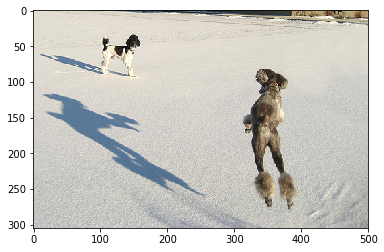

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

img = mpimg.imread('image_data/Flicker8k_Dataset/2056042552_f59e338533.jpg')
plt.imshow(img, aspect='auto')
plt.show()

In [21]:
train_descriptions['2056042552_f59e338533']

['startseq grey dog is jumping toward black and white dog in the snow endseq',
 'startseq two dogs playing on the beach endseq',
 'startseq two dogs play on the beach endseq',
 'startseq two french poodles romp on snowy field endseq',
 'startseq two poodles are in the snow and one is jumping high endseq']

### Summary
            For every word, we are adding 'startseq' at the beginning of the description and 'endseq' at the end descriptions.  

### Loading the InceptionV3 model

In [22]:
model = InceptionV3(weights='imagenet') #loading the model
print(model.summary()) #print summary

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Summary
            Loading the predefined InceptionV3 model .Here we are using transfer learning strategy .

### Creating new model with bottleneck features

In [23]:
model_bottleneck=Model(model.input,model.layers[-2].output) #creating a new model with removing last layer in the model

### Summary
            Here we are creating a new model by removing last layer in the model

### Preprocess the input image

In [24]:
def preprocess(image_path): # Here we aare preprocessing the image
    img=image.load_img('image_data/Flicker8k_Dataset/'+image_path,target_size=(299,299)) #Setting the image size to(224,224)
    x=image.img_to_array(img) #converting the image to numpy array
    x=np.expand_dims(x,axis=0) #adding one more dimension
    x=preprocess_input(x) 
    return x

### Encoding the image

In [25]:
def encode(image): # Here we are encoding the image as of our requirement
    image=preprocess(image) # Preprocessing the image
    fea_vec=model_bottleneck.predict(image) # Getting the encoded image feature vector from the given image
    fea_vec=np.reshape(fea_vec, fea_vec.shape[1]) # reshaping the image from (1,2048) to (2048,)
    return fea_vec

### Encoding train images

In [28]:
encoded_train_img=dict() #creating a dictionary
for img in train_img: #for evey image
    image_id = img.split('.')[0] # Removing '.jpg' extension 
    encoded_train_img[image_id]=encode(img) # for every image_id as key, extracted vector of size 2048 is stored as value

### Summary
                Encoding the image
                Steps
                    *. Converting the image to numpy array
                    *. With the created new model, we are predicting the image.
                    *. Reshaping the image

In [29]:
import pickle
with open("image_data/encoded_train_images.pkl", "wb") as encoded_pickle: #creating a file
    pickle.dump(encoded_train_img, encoded_pickle) #storing the file as pickle file

### Summary
                Saving the data of encoded train images in a pickle file.

### Encoding test images

In [30]:
encoded_test_img=dict() #creating a dictionary
for img in test_img: #for evey test image
    image_id = img.split('.')[0] #removing '.jpg' extension
    encoded_test_img[image_id]=encode(img) # for every image_id as key,extracted vectorof size 2048 is stored as value

In [31]:
import pickle
with open("image_data/encoded_test_images.pkl", "wb") as encoded_pickle: #creating a file
    pickle.dump(encoded_test_img, encoded_pickle)# storing the file as pikle file

### Summary
                Saving the data of encoded test images in a pickle file.

### Loading the trained features

In [26]:
train_features=load(open('image_data/encoded_train_images.pkl','rb')) #loading the stored file
print('Total no. of train features are :', len(train_features))

Total no. of train features are : 6000


In [27]:
train_captions=[] # creating a list
for key,values in train_descriptions.items(): #for every image_id
    for val in values: # for every description
        train_captions.append(val) # appending all the descriptions into a list
len(train_captions) # we will be 30000 descriptions

30000

### Summary
            *. Here we are loading all the descriptions into a list.
            *. There are 30000 captions(6000 images * 5 descriptions)

### Counting words which occur more times

In [28]:
word_count_threshold=10
word_count={}
for sent in train_captions: #for every caption
    for word in sent.split(' '): #for every word split by white space
        word_count[word]=word_count.get(word,0)+1 # counting occurence of each word
vocab=[word for word in word_count if word_count[word] >= word_count_threshold] #checking the condition
print('preprocessed words %d -> %d' % (len(word_count), len(vocab)))

preprocessed words 7578 -> 1651


### Summary
               From the vocabulary of words, we are choosing only the words, which occur more than 10 times in the vocabulary

### Indexing words

In [29]:
index_to_word={} # Creating a empty dictionary
word_to_index={} # Creating a empty dictionary
index=1
for word in vocab: #For every word in vocabulary
    index_to_word[index]=word #For every index , we are assigning a word
    word_to_index[word]=index # For every word, we are assigning an index
    index+=1

### Summary
            *. We are assigning a index to every word
            *. We are assigning a word to every index

### Finding the maximum length of descriptions

In [30]:
def lines(descriptions):
    desc=list()  # Creating a empty list 
    for key in descriptions.keys(): # for every image id
        for description in descriptions[key]: # For every description for that image
            desc.append(description) # Loading all the desciptions to desc
    return desc
def maximum_length(descriptions): 
    line=lines(descriptions) #loading the whole descriptions
    return max(len(d.split()) for d in line) # Splitting the words and returning the maximum length of descriptions
max_len= maximum_length(descriptions)
print("max length of words are :",max_len)

max length of words are : 32


### Summary
                Finding the max length of the descriptions for given train images.

### Generating all the input data

In [31]:
def data_generator(descriptions,photos, word_to_index,max_length,num_photos_per_batch):
    X1,X2,y=list(),list(),list()
    n=0
    for key,desc in descriptions.items(): #For every image and description
        n+=1
        photo=photos[key] #loading the image id
        for d in desc:
            seq = [word_to_index[word] for word in d.split(' ') if word in word_to_index] # Converting the word in descriptions to indexes
            for i in range(1,len(seq)): # for range of length of words in descriptions 
                in_seq,out_seq=seq[:i],seq[i] #Taking word as input and next occuring word as output
                in_seq=pad_sequences([in_seq],maxlen=max_len)[0] #padding the word upto maximum length of descriptions
                out_seq=to_categorical([out_seq], num_classes=vocabulary_size)[0] #Converting the target value to a categorical value
                X1.append(photo) #appending the encoded image feature
                X2.append(in_seq) # Appending the input sequence of word
                y.append(out_seq) # Appending the output sequence(next occuring word)
        if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0     

### Summary
            Generating input data
            Steps
                    *. We are taking every description
                    *. Taking every word with padding upto maximum length of description and taking next occurring word as target word.
                    *. Instead of words, we are taking index of the words
                    * Coverting all the target values to the categorical values

### Loading GlOVE model

In [32]:
glove_dir='GLOVE'
glove_vectors={} #Creating a empty dictionary
f=open(os.path.join(glove_dir,'glove.6B.200d.txt'),encoding='utf-8') #loading the glove directory
for file_line in f:  # for every line in glove file
    line=file_line.split() #Splitting the line 
    word=line[0] # First index of that line is word
    coefs = np.asarray(line[1:], dtype='float32') # remaining index are coefficients for that word 
    glove_vectors[word] = coefs #in the dictionary, we are storing the word as key and coefficient of word as value for that word
f.close()
print(' No. of glove vector are ' , len(glove_vectors))

 No. of glove vector are  400000


### Summary
                Loading all the vectors for each word.

In [33]:
vocabulary_size=(len(word_to_index))+1
vocabulary_size

1652

In [34]:
dim_vector=200 #Taking only 200 dimensional vector
word_matrix=np.zeros((vocabulary_size, dim_vector)) #creating a matrix with all zeros
for word,index in word_to_index.items(): #for every word
    glove_vec=glove_vectors.get(word) # for every word, we are loading the coefficient of that word
    if glove_vec is not None:
        word_matrix[index]=glove_vec

### Summary
            For every word, we are just taking the 200 dimensions only. 

In [35]:
word_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.16711   ,  0.016552  , -0.56985998, ...,  0.57885998,
        -0.25709   ,  0.45908001],
       [-0.0029923 , -0.79718   ,  0.0061861 , ...,  0.78188002,
        -0.52678001,  0.34862   ],
       ...,
       [ 0.16773   ,  0.26133999, -0.41501001, ...,  0.10062   ,
        -0.010848  ,  0.11345   ],
       [ 0.35479   , -0.32782999, -1.06869996, ...,  0.070415  ,
        -0.097698  , -0.41589999],
       [-0.26923999,  0.025036  , -0.84415001, ...,  0.10625   ,
        -0.30094999,  0.101     ]])

In [36]:
word_matrix.shape

(1652, 200)

In [37]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1) #activation unit a relu
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocabulary_size,dim_vector, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2) #LSTM layer
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocabulary_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

### Summary
                * Embedding all the inputs
                *. Using 'relu' activation
                *. Here we are using LSTM layer

In [38]:
model.layers[2]

In [39]:
model.layers[2].set_weights([word_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam') #Adam optimizer

### Summary
            *. Using loss as categorical crossentropy
            *. Using adam optimizer

In [40]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [41]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, word_to_index, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('model_weights/model_1' + str(i) + '.h5')
    #model.save_weights('model_weights.h5')
    model.save_weights('model_weights.h5')

Epoch 1/1
2000/2000 [==============================] - 972s 486ms/step - loss: 4.1086
Epoch 1/1
2000/2000 [==============================] - 957s 478ms/step - loss: 3.4116
Epoch 1/1
2000/2000 [==============================] - 958s 479ms/step - loss: 3.1937
Epoch 1/1
2000/2000 [==============================] - 961s 480ms/step - loss: 3.0625
Epoch 1/1
2000/2000 [==============================] - 965s 482ms/step - loss: 2.9674
Epoch 1/1
2000/2000 [==============================] - 958s 479ms/step - loss: 2.8955
Epoch 1/1
2000/2000 [==============================] - 961s 481ms/step - loss: 2.8379
Epoch 1/1
2000/2000 [==============================] - 960s 480ms/step - loss: 2.7930
Epoch 1/1
2000/2000 [==============================] - 959s 479ms/step - loss: 2.7526
Epoch 1/1
2000/2000 [==============================] - 961s 481ms/step - loss: 2.7186


In [42]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [43]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, word_to_index, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('model_weights/model_1' + str(i) + '.h5')
    #model.save_weights('model_weights.h5')
    model.save_weights('model_weights.h5')

Epoch 1/1
1000/1000 [==============================] - 724s 724ms/step - loss: 2.6413
Epoch 1/1
1000/1000 [==============================] - 717s 717ms/step - loss: 2.6157
Epoch 1/1
1000/1000 [==============================] - 718s 718ms/step - loss: 2.5957
Epoch 1/1
1000/1000 [==============================] - 717s 717ms/step - loss: 2.5778
Epoch 1/1
1000/1000 [==============================] - 719s 719ms/step - loss: 2.5611
Epoch 1/1
1000/1000 [==============================] - 720s 720ms/step - loss: 2.5399
Epoch 1/1
1000/1000 [==============================] - 723s 723ms/step - loss: 2.5222
Epoch 1/1
1000/1000 [==============================] - 715s 715ms/step - loss: 2.5060
Epoch 1/1
1000/1000 [==============================] - 717s 717ms/step - loss: 2.4904
Epoch 1/1
1000/1000 [==============================] - 721s 721ms/step - loss: 2.4800


In [44]:
model.load_weights('model_weights.h5') #loading the weights

In [45]:
images="image_data/Flicker8k_Dataset/"
test_images=load(open('image_data/encoded_test_images.pkl','rb'))

In [46]:
def greedySearch(photo): 
    in_text = 'startseq' 
    for i in range(max_len): # predicting  words max upto size of max length
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index] # Finding the index of words
        sequence = pad_sequences([sequence], maxlen=max_len) #padding the sequence of words upto max length of description
        yhat = model.predict([photo,sequence], verbose=0) # predicting the next word from the inputted padded sequence 
        yhat = np.argmax(yhat) 
        word = index_to_word[yhat] #Finding the index for the predicted word
        in_text += ' ' + word # adding the predicted word to the text sequence
        if word == 'endseq': 
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Test case :1

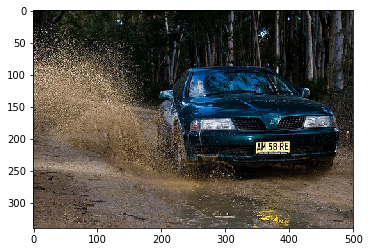

Greedy: car driving through mud puddle


In [53]:
z=0
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :2

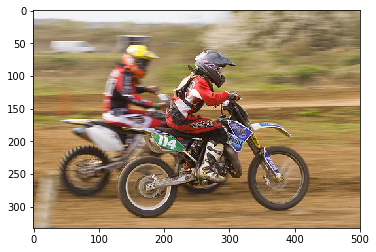

Greedy: motorcyclist is riding on racetrack


In [59]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :3

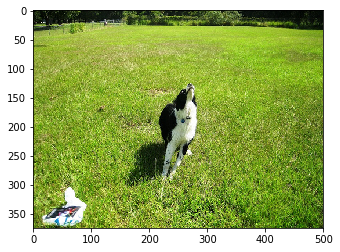

Greedy: dog is running through the grass


In [63]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :4

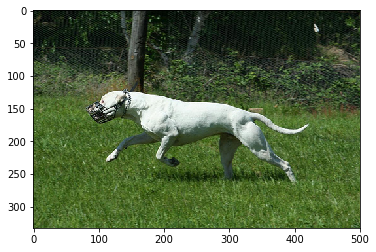

Greedy: dog is running on the grass


In [65]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :5

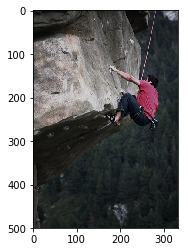

Greedy: man climbing sheer rock face


In [69]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :6

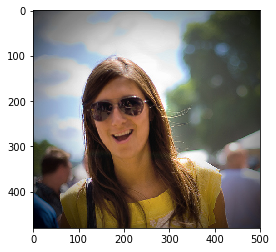

Greedy: woman with black hair and sunglasses smiles


In [70]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly, but there is some semantic error

### Test case :7

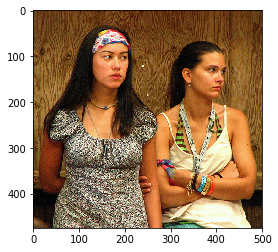

Greedy: two women in black posing for picture


In [77]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :8

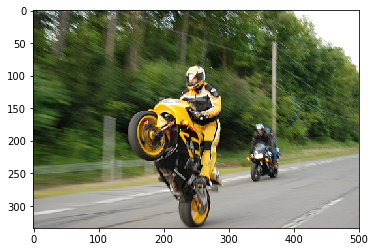

Greedy: man in yellow outfit riding motorcycle


In [79]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :9

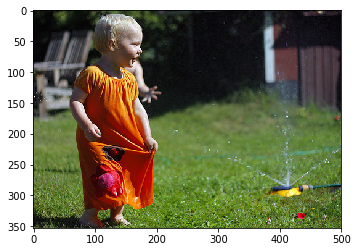

Greedy: young boy in blue shirt plays with toy


In [82]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted worse, colour of shirt is not predicted correctly

### Test case :10

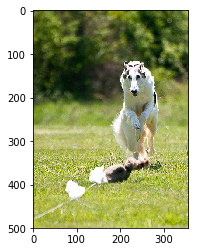

Greedy: dog is running through field


In [83]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :11

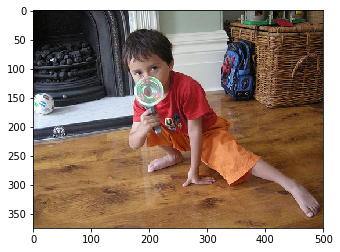

Greedy: man in blue shirt is sitting on the grass


In [84]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted only one sitting position correctly, shirt colour and floor is predicted incorrectly

### Test case :12

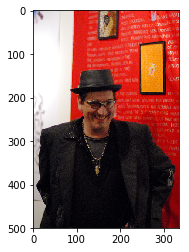

Greedy: man in black shirt and glasses is sitting on bench


In [85]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :13

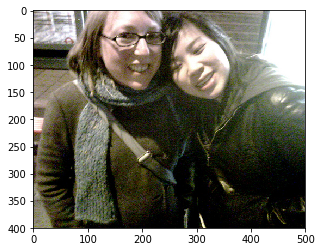

Greedy: woman with brown hair and man in black shirt smile for the camera


In [86]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :14

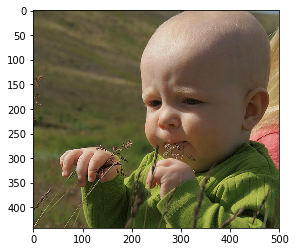

Greedy: young boy with blue shirt and blue shirt is holding football in his mouth


In [87]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output  : May be model predicted football because of the shape in the image

### Test case :15

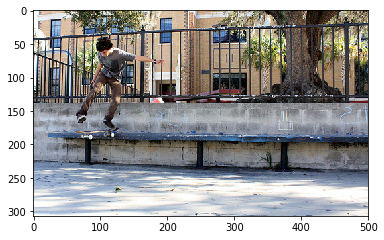

Greedy: skateboarder doing trick on ramp


In [88]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :16

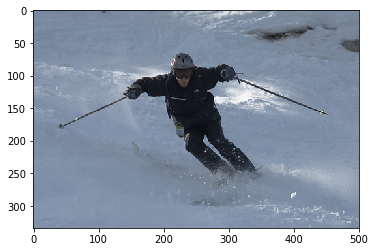

Greedy: man in red jacket is skiing on thin mountain


In [90]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly,but the colour of the shirt is predicted wrong

### Test case :17

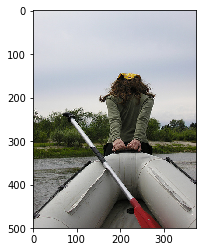

Greedy: the man is sitting on boat looking at the sunset


In [91]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Test case :18

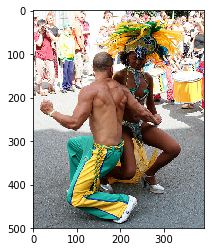

Greedy: man in black shirt is standing next to man in suit


In [93]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [ ]:
#### Output : Model predicted worse

### Test case :19

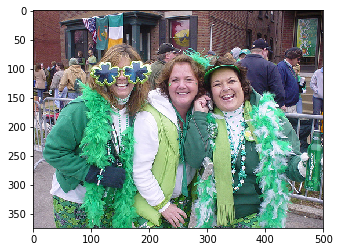

Greedy: two girls are smiling and laughing


In [97]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted partially correct, instead of three girls, model outputted only two 

### Test case :20

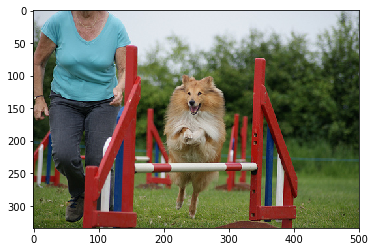

Greedy: dog jumping over hurdle


In [112]:
z+=1
pic = list(test_images.keys())[z]
image = test_images[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

#### Output : Model predicted correctly

### Conclusion

        *. Loading the text data
        *. Cleaning the text data and saving the text data in a file
        *. Loading the Inception V3 bottleneck features
        *. For every image, we are loading the bottleneck features for that image
        *. Loading the glove models
        *. For every word, we are loading the 200 dimension glove vectors
        *. Taking max length of the descriptions
        *. We are taking every description
        *. Taking every word with padding upto maximum length of description and taking next occurring word as target word.
        *. Instead of words, we are taking index of the words
        * Coverting all the target values to the categorical values
        * Training the model with LSTM layer
        *. In Greedy search, we are predicting the target index, we are outputting the word for that index.

## Reference

            1.https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
            2.https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
            3.https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb
            4.https://www.youtube.com/watch?v=yk6XDFm3J2c
            5.https://arxiv.org/abs/1411.4555
            6.https://arxiv.org/abs/1703.09137